## Load Libraries

In [1]:
# libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_regression

import xgboost as xgb
from xgboost import XGBClassifier, plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

# Load the training data from the specified address
train_data = pd.read_csv('/kaggle/input/adult-income-classification-challenge-map-6990-mi/train.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Pre-processing

In [2]:
# Drop null records
train_data = train_data.dropna()

# Check for null values
train_data.isnull().sum()

ID                0
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Income            0
dtype: int64

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39073 entries, 0 to 39072
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              39073 non-null  int64 
 1   age             39073 non-null  int64 
 2   workclass       39073 non-null  object
 3   fnlwgt          39073 non-null  int64 
 4   education       39073 non-null  object
 5   education-num   39073 non-null  int64 
 6   marital-status  39073 non-null  object
 7   occupation      39073 non-null  object
 8   relationship    39073 non-null  object
 9   race            39073 non-null  object
 10  sex             39073 non-null  object
 11  capital-gain    39073 non-null  int64 
 12  capital-loss    39073 non-null  int64 
 13  hours-per-week  39073 non-null  int64 
 14  native-country  39073 non-null  object
 15  Income          39073 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 4.8+ MB


#### There are no null values; however, there are some records with '?'.
#### The columns: 'workclass', 'native-country', and 'occupation' will be represented as 0 during the label encoding.

In [4]:
# Filter rows that contain '?' in 'workclass', 'native-country', and 'occupation' columns
work_empty = train_data[train_data['workclass'].str.contains('?', regex = False)]
native_country_empty = train_data[train_data['native-country'].str.contains('?', regex=False)]
occupation_empty = train_data[train_data['occupation'].str.contains('?', regex=False)]

# Combine the indices of all filtered rows
filtered_indices = set().union(work_empty.index, native_country_empty.index, occupation_empty.index)

# Count records with '?'
print(len(filtered_indices))

2890


In [5]:
category_summary = train_data.describe(include = "object")
print(category_summary)

       workclass education       marital-status       occupation relationship  \
count      39073     39073                39073            39073        39073   
unique         9        16                    7               15            6   
top      Private   HS-grad   Married-civ-spouse   Prof-specialty      Husband   
freq       27141     12582                17951             4915        15822   

          race    sex  native-country  
count    39073  39073           39073  
unique       5      2              42  
top      White   Male   United-States  
freq     33414  26170           35059  


In [6]:
# frequency table for sex
train_data['sex'].value_counts()

 Male      26170
 Female    12903
Name: sex, dtype: int64

In [7]:
# frequency table for race
train_data['race'].value_counts()

 White                 33414
 Black                  3741
 Asian-Pac-Islander     1215
 Amer-Indian-Eskimo      366
 Other                   337
Name: race, dtype: int64

In [8]:
# frequency table for relationship
train_data['relationship'].value_counts()

 Husband           15822
 Not-in-family     10061
 Own-child          6033
 Unmarried          4087
 Wife               1852
 Other-relative     1218
Name: relationship, dtype: int64

In [9]:
# frequency table for occupation
train_data['occupation'].value_counts()

 Prof-specialty       4915
 Exec-managerial      4893
 Craft-repair         4872
 Adm-clerical         4466
 Sales                4413
 Other-service        3900
 Machine-op-inspct    2462
 ?                    2241
 Transport-moving     1908
 Handlers-cleaners    1678
 Farming-fishing      1181
 Tech-support         1124
 Protective-serv       806
 Priv-house-serv       200
 Armed-Forces           14
Name: occupation, dtype: int64

In [10]:
# frequency table for marital-status
train_data['marital-status'].value_counts()

 Married-civ-spouse       17951
 Never-married            12835
 Divorced                  5298
 Separated                 1233
 Widowed                   1226
 Married-spouse-absent      502
 Married-AF-spouse           28
Name: marital-status, dtype: int64

In [11]:
# frequency table for workclass
train_data['workclass'].value_counts()

 Private             27141
 Self-emp-not-inc     3068
 Local-gov            2535
 ?                    2233
 State-gov            1556
 Self-emp-inc         1363
 Federal-gov          1150
 Without-pay            19
 Never-worked            8
Name: workclass, dtype: int64

In [12]:
# frequency table for education
train_data['education'].value_counts()

 HS-grad         12582
 Some-college     8739
 Bachelors        6379
 Masters          2131
 Assoc-voc        1657
 11th             1451
 Assoc-acdm       1303
 10th             1108
 7th-8th           756
 Prof-school       654
 9th               611
 12th              532
 Doctorate         468
 5th-6th           427
 1st-4th           213
 Preschool          62
Name: education, dtype: int64

In [13]:
# frequency table for countries
train_data['native-country'].value_counts()

 United-States                 35059
 Mexico                          790
 ?                               688
 Philippines                     231
 Germany                         159
 Puerto-Rico                     143
 Canada                          142
 El-Salvador                     124
 India                           120
 Cuba                            113
 China                            97
 England                          96
 South                            96
 Dominican-Republic               86
 Jamaica                          84
 Italy                            83
 Poland                           74
 Japan                            70
 Guatemala                        70
 Columbia                         69
 Vietnam                          67
 Portugal                         61
 Haiti                            60
 Taiwan                           53
 Iran                             47
 Ecuador                          39
 Peru                             37
 

## Feature Engineering

#### Creating a dictionary to convert categories to integers

In [14]:
train_data[['education', 'education-num']].groupby(['education'], as_index=False).mean().sort_values(by='education-num', ascending=False)

,education,education-num
10,Doctorate,16.0
14,Prof-school,15.0
12,Masters,14.0
9,Bachelors,13.0
7,Assoc-acdm,12.0
8,Assoc-voc,11.0
15,Some-college,10.0
11,HS-grad,9.0
2,12th,8.0
1,11th,7.0


In [15]:
# Function to map multiple columns using a dictionary
def map_columns(df, mapping_dict):
    for column, mapping in mapping_dict.items():
        df[column] = df[column].map(mapping)
    return df

# Create mapping dictionaries for multiple columns
work_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['workclass']))}
marital_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['marital-status']))}
occupation_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['occupation']))}
relationship_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['relationship']))}
race_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['race']))}
sex_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['sex']))}
country_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['native-country']))}

# Map the dictionaries to the respective columns
mapping_dict = {
    'workclass': work_mapping,
    'occupation' : occupation_mapping,
    'marital-status' : marital_mapping,
    'relationship' : relationship_mapping,
    'race' : race_mapping,
    'sex' : sex_mapping,
    'native-country' : country_mapping
    
}

# Apply the mapping function to the DataFrame
df_mapped = map_columns(train_data.copy(), mapping_dict)
df_mapped.head()

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,34496,37,4,193106,Bachelors,13,4,12,1,4,0,0,0,30,39,0
1,18592,56,5,216636,12th,8,2,4,0,4,1,0,1651,40,39,0
2,12563,53,4,126977,HS-grad,9,5,3,1,4,1,0,0,35,39,0
3,553,72,4,205343,11th,7,6,1,4,4,0,0,0,40,39,0
4,3480,46,7,106705,Masters,14,4,4,1,4,0,0,0,38,39,0


- A new column 'net-capital-gains' was created by subtracting 'capital-loss' from 'capital-gains'

In [16]:
# Create a new column 'net-capital-gains' by subtracting 'capital-loss' from 'capital-gains'
df_mapped['net-capital-gains'] = df_mapped['capital-gain'] - df_mapped['capital-loss']

#### During the X-matrix process, 
- The feature 'education' was deleted because the 'education-num' is in the format needed to process the model.

In [17]:
# Baseline-model
X0 = df_mapped.drop(['Income','ID', 'education', 'capital-gain', 'capital-loss'], axis=1)
y0 = df_mapped['Income']

# Records comparison for the X-matrix, Y-matrix
df_mapped.shape, X0.shape, y0.shape
X0.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,net-capital-gains
0,37,4,193106,13,4,12,1,4,0,30,39,0
1,56,5,216636,8,2,4,0,4,1,40,39,-1651
2,53,4,126977,9,5,3,1,4,1,35,39,0
3,72,4,205343,7,6,1,4,4,0,40,39,0
4,46,7,106705,14,4,4,1,4,0,38,39,0


## Information Gain

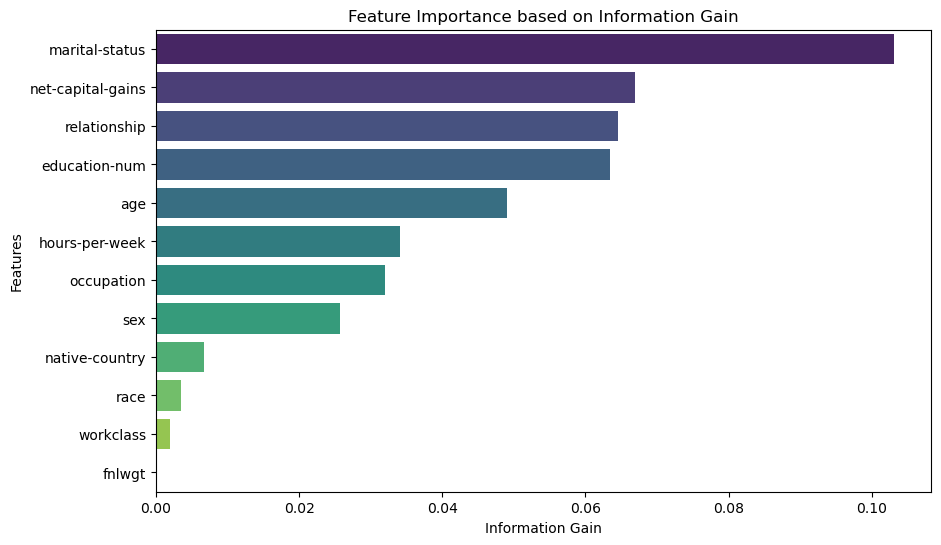

In [18]:
# Calculate Information Gain (IG) scores using mutual_info_regression
ig = mutual_info_regression(X0, y0)

# Create a DataFrame with feature names and their corresponding IG scores
feature_scores_df = pd.DataFrame({'Feature': X0.columns, 'Information_Gain': ig})

# Sort the features based on IG scores from most important to least important
sorted_features = feature_scores_df.sort_values(by='Information_Gain', ascending=False)

# Plot the sorted features using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Information_Gain', y='Feature', data=sorted_features, palette='viridis')
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.title('Feature Importance based on Information Gain')
plt.show()

## Correlation Analysis

In [19]:
df_mapped.corr(numeric_only=True)

,ID,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income,net-capital-gains
ID,1.000000,0.006120,0.000386,-0.001257,-0.000463,0.005240,-0.001021,-0.004329,0.003425,-0.006450,-0.000153,-0.000289,-0.000801,0.003297,-0.005263,-0.000137
age,0.006120,1.000000,0.017063,-0.078913,0.025160,-0.262965,-0.015874,-0.261558,0.028803,0.085835,0.074589,0.058381,0.066366,-0.006166,0.229297,0.071104
workclass,0.000386,0.017063,1.000000,-0.013619,0.055457,-0.067621,0.260443,-0.091279,0.050740,0.092232,0.036362,0.014368,0.140063,-0.009069,0.051068,0.035446
fnlwgt,-0.001257,-0.078913,-0.013619,1.000000,-0.037353,0.027320,-0.000817,0.008234,-0.031349,0.028497,0.000148,-0.003136,-0.009965,-0.050185,-0.005555,0.000321
education-num,-0.000463,0.025160,0.055457,-0.037353,1.000000,-0.071036,0.110456,-0.090045,0.030706,0.009749,0.120936,0.080191,0.146947,0.050955,0.335365,0.116088
marital-status,0.005240,-0.262965,-0.067621,0.027320,-0.071036,1.000000,-0.018700,0.191403,-0.071436,-0.128174,-0.045127,-0.030285,-0.184671,-0.022092,-0.199886,-0.043298
occupation,-0.001021,-0.015874,0.260443,-0.000817,0.110456,-0.018700,1.000000,-0.078408,0.006315,0.078759,0.023738,0.019918,0.082628,-0.014983,0.080103,0.022555
relationship,-0.004329,-0.261558,-0.091279,0.008234,-0.090045,0.191403,-0.078408,1.000000,-0.121303,-0.578602,-0.056710,-0.055644,-0.247478,-0.002364,-0.251772,-0.053435
race,0.003425,0.028803,0.050740,-0.031349,0.030706,-0.071436,0.006315,-0.121303,1.000000,0.086094,0.010477,0.019639,0.042146,0.140067,0.070195,0.009353
sex,-0.006450,0.085835,0.092232,0.028497,0.009749,-0.128174,0.078759,-0.578602,0.086094,1.000000,0.048068,0.046695,0.226124,-0.011369,0.214967,0.045319


In [20]:
# Return Highly correlated features
def correlation(df, threshold):
    correlated_cols = set()
    corr_matrix = df.corr(numeric_only=True)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                correlated_cols.add(colname)
    return correlated_cols

correlation(df_mapped, 0.9)

{'net-capital-gains'}

## Multicollinearity Analysis
#### The VIF values are less than 20. Thus, we can infer there is no multicollinearity. 

In [21]:
# Checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X0.columns
vif['VIF'] = [variance_inflation_factor(X0, i) for i in range(X0.shape[1])]

print("Variance Inflation Factor (VIF) values:")
print(vif)

Variance Inflation Factor (VIF) values:
              Feature        VIF
0                 age   8.439213
1           workclass   8.440264
2              fnlwgt   4.042015
3       education-num  15.115721
4      marital-status   3.983175
5          occupation   3.714293
6        relationship   2.591980
7                race  17.698156
8                 sex   4.408768
9      hours-per-week  12.052385
10     native-country  19.733083
11  net-capital-gains   1.036068


#### VIF does not represent a problem for any of the features.

## Data Exploration

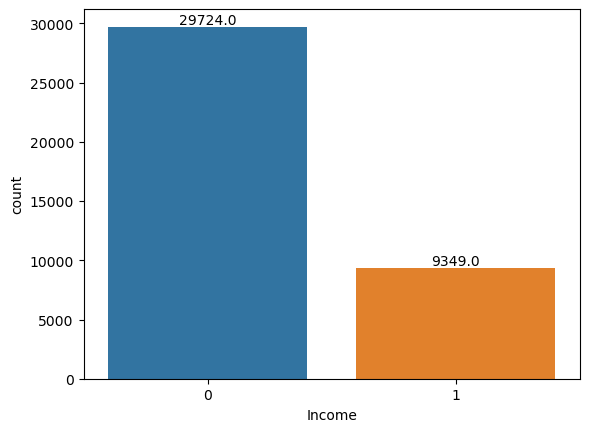

In [22]:
# Set the order of the count plot 
count_order = train_data['Income'].unique()

# Plot the count of unique values in the 'Income' column
sns.countplot(x='Income', data=train_data, order=count_order)

# Get the counts for each unique value in the 'Income' column
value_counts = train_data['Income'].value_counts()

# Add labels on the bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
# Show the plot
plt.show()
plt.close()

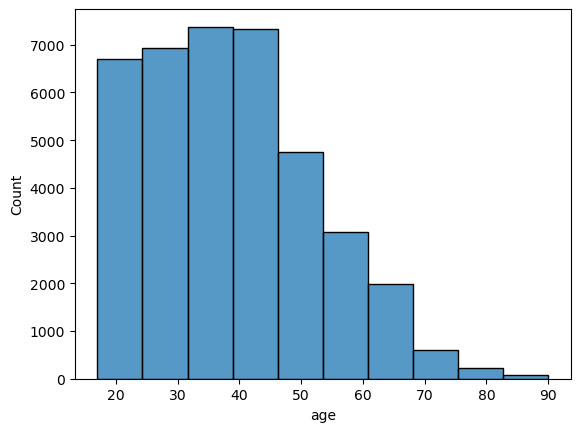

In [23]:
# age histogram
sns.histplot(df_mapped['age'], bins=10)

# Show the plot
plt.show()
plt.close()

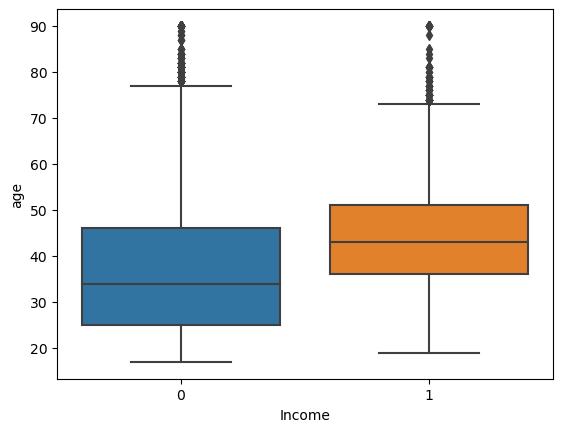

In [24]:
# Plot boxplot - age vs income
sns.boxplot(x='Income', y='age', data=train_data)

# Show the plot
plt.show()
plt.close()

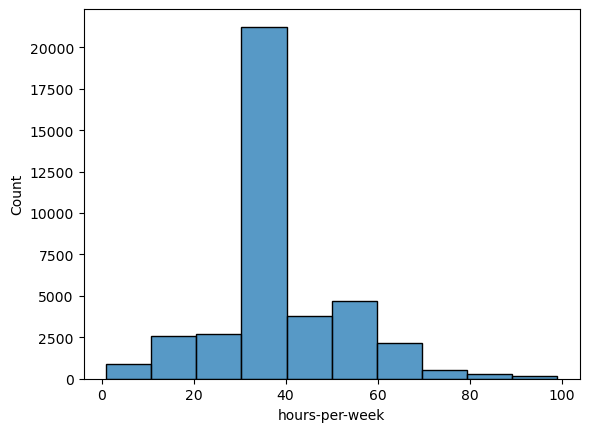

In [25]:
# hours per week histogram
sns.histplot(df_mapped['hours-per-week'], bins=10)

# Show the plot
plt.show()
plt.close()

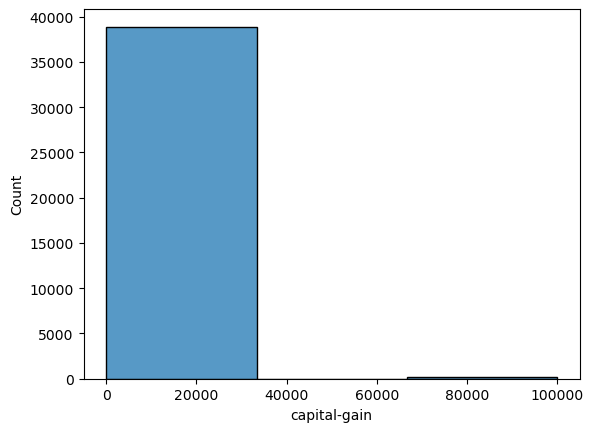

In [26]:
# Capital Gains histogram
sns.histplot(df_mapped['capital-gain'], bins=3)

# Show the plot
plt.show()
plt.close()

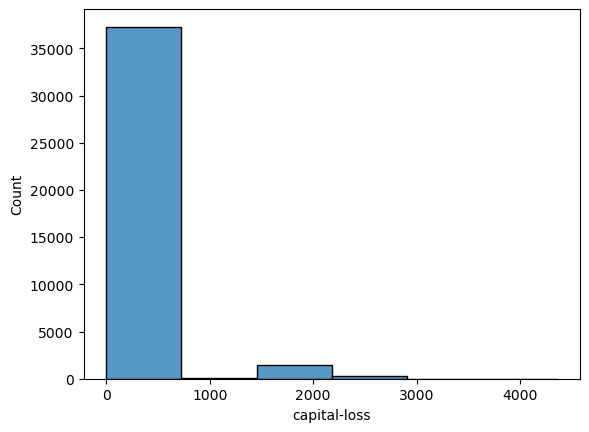

In [27]:
# Capital Loss histogram
sns.histplot(df_mapped['capital-loss'], bins=6)

# Show the plot
plt.show()
plt.close()

## Create X, and Y matrix after Information Gain
- Race, final weight, Native country, capital-gain, and capital-loss will be dropped from the model.

In [28]:
# Model-3
X = df_mapped.drop(['Income','ID', 'education', 'fnlwgt', 'race', 'native-country', 'capital-gain', 'capital-loss'], axis=1)
y = df_mapped['Income']

# Records comparison for the X-matrix, Y-matrix
df_mapped.shape, X.shape, y.shape
X.head()

,age,workclass,education-num,marital-status,occupation,relationship,sex,hours-per-week,net-capital-gains
0,37,4,13,4,12,1,0,30,0
1,56,5,8,2,4,0,1,40,-1651
2,53,4,9,5,3,1,1,35,0
3,72,4,7,6,1,4,0,40,0
4,46,7,14,4,4,1,0,38,0


## Training and Test sets

In [29]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45, stratify=y)

## Feature Scaling
#### Standarizing the data

In [30]:
# Feature scaling

# Create a standar scaler instance
scale = StandardScaler()

# tranform the data with Standard Scaling
X_train_std = scale.fit_transform(X_train)
X_test_std = scale.transform(X_test)

In [31]:
X.shape, X_train.shape, X_test.shape

((39073, 9), (27351, 9), (11722, 9))

# Training of Different Models

### Logistic Regression

In [32]:
# Logistic Regression

# Create a Logistic Regression instance
lr = LogisticRegression()

# Train the Logistic Regression model
lr_model = lr.fit(X_train_std, y_train)

# Make predictions on the test set
lr_pred = lr_model.predict(X_test_std)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy: %.3f"% lr_accuracy)

Logistic Regression Accuracy: 0.819


### L1 Regularization

In [33]:
# L1 regularization (LASSO)
from sklearn.linear_model import LogisticRegression

# Create an L1 instance
l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# Note that C=1.0 is the default. You can increase
# or decrease it to make the regulariztion effect
# stronger or weaker, respectively.

# Train the L1 model
l1.fit(X_train_std, y_train)

# Calculate accuracy
print('Training accuracy:', l1.score(X_train_std, y_train))
print('Test accuracy:', l1.score(X_test_std, y_test))

Training accuracy: 0.8206281305985156
Test accuracy: 0.8188022521753967


### Perceptron

In [34]:
# Perceptron

# Create a Perceptron instance
perceptron = Perceptron()
#perceptron = Perceptron(eta=0.1, random_state=1)

# Train the perceptron model
perceptron.fit(X_train_std, y_train)

# Make predictions on the test set
perceptron_pred = perceptron.predict(X_test_std)

# Calculate accuracy
perceptron_accuracy = accuracy_score(y_test, perceptron_pred)
print("Perceptron Accuracy: %.3f"% perceptron_accuracy)



Perceptron Accuracy: 0.715


### Support Vector Machine

In [35]:
# SVM - Support Vector Machine

# Create SVM instance
svm = SVC()

# Train the SVM model
svm.fit(X_train_std, y_train)

# Make predictions on the test set
svm_pred = svm.predict(X_test_std)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy: %.3f"% svm_accuracy)



SVM Accuracy: 0.847


### Support Vector Machine with Kernerl RBF

In [36]:
# SVM - Support Vector Machine

# Create SVM instance
svm = SVC(kernel='rbf')

# Train the SVM model
svm.fit(X_train_std, y_train)

# Make predictions on the test set
svm_pred = svm.predict(X_test_std)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy: %.3f"% svm_accuracy)

SVM Accuracy: 0.847


### K-Nearest Neighbors (KNN) Model

In [37]:
# K-Nearest Neighbors (KNN) Model

# Creat KNN instance
knn = KNeighborsClassifier(n_neighbors=5)  # Using 5 neighbors, you can change this value as needed

# Train the KNN model
knn.fit(X_train_std, y_train)

# Make predictions on the validation set
knn_pred = knn.predict(X_test_std)

# Calculate accuracy of the KNN model
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy: %.3f" % knn_accuracy)

KNN Accuracy: 0.828


### Decision Tree

In [38]:
# Decision Tree

# Create a Decision Tree instance
decision_tree = DecisionTreeClassifier()

# Train the Decision Tree model
decision_tree.fit(X_train_std, y_train)

# Make predictions on the test set
tree_pred = decision_tree.predict(X_test_std)

# Calculate accuracy
tree_accuracy = accuracy_score(y_test, tree_pred)
print("Decision Tree Accuracy: %.3f"% tree_accuracy)


Decision Tree Accuracy: 0.810


### Random Forest

In [39]:
# Random Forest

# Create a Random Forest instance
random_forest = RandomForestClassifier()

# Train the Random Forest model
random_forest.fit(X_train_std, y_train)

# Make predictions on the test set
forest_pred = random_forest.predict(X_test_std)

# Calculate accuracy
forest_accuracy = accuracy_score(y_test, forest_pred)
print("Random Forest Accuracy: %.3f"% forest_accuracy)


Random Forest Accuracy: 0.846


In [40]:
# Random Forest using parameter tuning
rf = RandomForestClassifier(50, max_depth=15, max_features=15)

# Train the Random Forest model
rf.fit(X_train_std, y_train)

# Make predictions on the test set
forest_pred = rf.predict(X_test_std)

# Calculate accuracy
forest_norm_accuracy = accuracy_score(y_test, forest_pred)
print("Random Forest Accuracy: %.5f"% forest_norm_accuracy)

Random Forest Accuracy: 0.86129


### Gradient Boosting

In [41]:
# Create a Gradient Boosting instance
gradBoost = GradientBoostingClassifier()

# Fit the model to the training data
gradBoost.fit(X_train_std, y_train)

# Make predictions on the test set
grad_pred = gradBoost.predict(X_test_std)

# Calculate the accuracy of the model
grad_accuracy = accuracy_score(y_test, grad_pred)
print("Gradient Boosting Accuracy: %.5f"% grad_accuracy)

Gradient Boosting Accuracy: 0.86888


### XG Boosting

In [42]:
# XG Boosting

# Create a XG Boosting instance
xg_boost = XGBClassifier()

# Fit the model to the training data
xg_boost.fit(X_train_std, y_train)

# Make predictions on the test set
xg_pred = xg_boost.predict(X_test_std)

# Calculate the accuracy of the model
xg_accuracy = accuracy_score(y_test, xg_pred)
print("XG Boosting Accuracy: %.5f"% xg_accuracy)

XG Boosting Accuracy: 0.87297


### XG Boosting - Parameter Tuning

In [43]:
# XG Boosting - parameter tuning

# Create a XG Boosting instance
xg_tune = XGBClassifier(learning_rate = 0.5,
                        max_depth = 2, 
                        n_estimators = 450)

# Fit the model to the training data
xg_tune.fit(X_train_std, y_train)

# Make predictions on the test set
xg_pred = xg_tune.predict(X_test_std)

# Calculate the accuracy of the model
xg_accuracy = accuracy_score(y_test, xg_pred)
print("XG Boosting Accuracy: %.5f"% xg_accuracy)

XG Boosting Accuracy: 0.87451


# -----------------------
# Test Submission
# -----------------------

In [44]:
# Load Test data
test_data = pd.read_csv('/kaggle/input/adult-income-classification-challenge-map-6990-mi/test.csv')
test_data.head()

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,40422,30,Private,378009,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
1,47739,54,State-gov,55861,Assoc-acdm,12,Divorced,Adm-clerical,Not-in-family,White,Male,0,0,39,United-States
2,519,21,?,204226,Some-college,10,Never-married,?,Unmarried,White,Female,0,0,35,United-States
3,8565,35,Private,306678,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,2885,0,40,United-States
4,31356,42,Local-gov,121012,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States


In [45]:
# Checking the lenght of the test dataset
test_data.shape

(9769, 15)

## Data Preparation for Test Submission
#### Search and delete records that contain question mark symbol '?'

In [46]:
# Delete empty data
test_data = test_data.dropna()

# Check empty records
test_data.isnull().sum()

ID                0
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

#### Create a dictionary to transform categories strings to integers

In [47]:
# Function to map multiple columns using a dictionary
def map_columns(df, mapping_dict):
    for column, mapping in mapping_dict.items():
        df[column] = df[column].map(mapping)
    return df

# Create mapping dictionaries for multiple columns
work_mapping_fin = {label: idx for idx, label in enumerate(np.unique(test_data['workclass']))}
marital_mapping_fin = {label: idx for idx, label in enumerate(np.unique(test_data['marital-status']))}
occupation_mapping_fin = {label: idx for idx, label in enumerate(np.unique(test_data['occupation']))}
relationship_mapping_fin = {label: idx for idx, label in enumerate(np.unique(test_data['relationship']))}
race_mapping_fin = {label: idx for idx, label in enumerate(np.unique(test_data['race']))}
sex_mapping_fin = {label: idx for idx, label in enumerate(np.unique(test_data['sex']))}
country_mapping_fin = {label: idx for idx, label in enumerate(np.unique(test_data['native-country']))}

# Map the dictionaries to the respective columns
mapping_dict_fin = {
    'workclass': work_mapping_fin,
    'occupation' : occupation_mapping_fin,
    'marital-status' : marital_mapping_fin,
    'relationship' : relationship_mapping_fin,
    'race' : race_mapping_fin,
    'sex' : sex_mapping_fin,
    'native-country' : country_mapping_fin
    
}

# Apply the mapping function to the DataFrame
test_mapped_fin = map_columns(test_data.copy(), mapping_dict_fin)
test_mapped_fin.head()

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,40422,30,4,378009,HS-grad,9,4,7,3,4,1,0,0,40,38
1,47739,54,7,55861,Assoc-acdm,12,0,1,1,4,1,0,0,39,38
2,519,21,0,204226,Some-college,10,4,0,4,4,0,0,0,35,38
3,8565,35,4,306678,HS-grad,9,2,7,0,4,1,2885,0,40,38
4,31356,42,2,121012,Some-college,10,2,4,0,4,1,0,0,45,38


In [48]:
# check data types
test_mapped_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9769 entries, 0 to 9768
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              9769 non-null   int64 
 1   age             9769 non-null   int64 
 2   workclass       9769 non-null   int64 
 3   fnlwgt          9769 non-null   int64 
 4   education       9769 non-null   object
 5   education-num   9769 non-null   int64 
 6   marital-status  9769 non-null   int64 
 7   occupation      9769 non-null   int64 
 8   relationship    9769 non-null   int64 
 9   race            9769 non-null   int64 
 10  sex             9769 non-null   int64 
 11  capital-gain    9769 non-null   int64 
 12  capital-loss    9769 non-null   int64 
 13  hours-per-week  9769 non-null   int64 
 14  native-country  9769 non-null   int64 
dtypes: int64(14), object(1)
memory usage: 1.1+ MB


## Feature Engineering
- A new column 'net-capital-gains' was created by subtracting 'capital-loss' from 'capital-gains'

In [49]:
# Create a new column 'net-capital-gains' by subtracting 'capital-loss' from 'capital-gains'
test_mapped_fin['net-capital-gains'] = test_mapped_fin['capital-gain'] - test_mapped_fin['capital-loss']

## X-matrix
#### The X-matrix has to match the training dataset

In [50]:
# Data Preparation
X_fin = test_mapped_fin.drop(['ID', 'education', 'fnlwgt', 'race', 'native-country', 'capital-loss', 'capital-gain'], axis=1)

# Preview the data
X_fin.shape

(9769, 9)

In [51]:
# Preview the X-matrix after preparation
X_fin.head()

,age,workclass,education-num,marital-status,occupation,relationship,sex,hours-per-week,net-capital-gains
0,30,4,9,4,7,3,1,40,0
1,54,7,12,0,1,1,1,39,0
2,21,0,10,4,0,4,0,35,0
3,35,4,9,2,7,0,1,40,2885
4,42,2,10,2,4,0,1,45,0


## Feature Scaling

In [52]:
# Feature Scaling
X_fin_std = scale.transform(X_fin)

## Gradient Boosting
#### Overall, Gradient Boosting is a versatile and reliable choice for classification tasks due to its ability to handle complex relationships, provide accurate predictions, and produce feature importance scores. Its robustness to outliers, and reduce overfitting makes it well-suited for predicting income levels accurately. However, it might require more careful tuning of hyperparameters compared to simpler models.
#### The XGBoost algorithm improves the way that splits are calculated after the first step. To make better decisions more data is added to help subsequent models. Moreover, the algorithm is able to skip records missing values, ending in nearly linear performance on the feature without missing values.

In [53]:
# Gradient Boosting
# Make predictions on the test set
final_predictions = xg_tune.predict(X_fin_std)

## DataFrame for Submission

In [54]:
# Create a DataFrame for submission
output = pd.DataFrame({'ID': test_data['ID'], 'Income': final_predictions})

# Write the DataFrame to a csv file
output.to_csv('submission.csv', index=False)
